In [19]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [20]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [150]:
dataset = 'cifar10'
proxy = 'plain'
data = dfs[dataset]

In [151]:
ylims = {'nwot': (550, 850), 'epe_nas': (0, 3000), 'zen': (-10, 300)}

def plt_ylim(prox):
    if prox not in ylims:
        return
    plt.ylim(ylims[prox][0], ylims[prox][1])

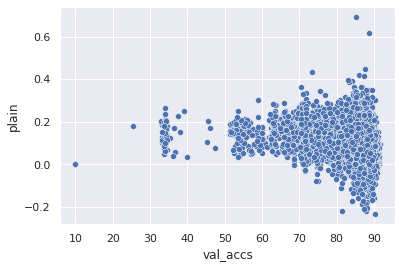

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
plt_ylim(proxy)
plt.show()

In [153]:
from zc_combine.operations import parse_ops_nb201, count_all_ops

count_set = {2, 3}
ops = parse_ops_nb201(data)
count_all_ops(data, ops, count_set)

In [154]:
# NB201 op names and edge indices to edges for convenience
OP_NAMES = ["Identity", "Zero", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['skip_connect', 'none', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

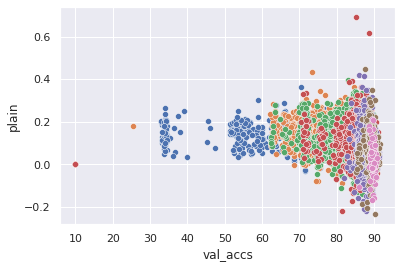

In [155]:
from zc_combine.operations import plot_clouds

plot_clouds(data, (2,3), proxy, vmax=7)
#plt.ylim(-1,1)
plt.show()

Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

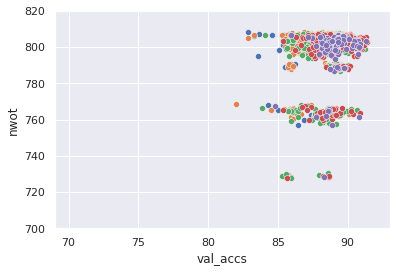

In [27]:
zoom = 4

data_zoom = data[data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=7)
plt.xlim(69, 93)
plt.ylim(700, 820)
plt.show()

However, if we examine the three clusters, then the lowest cluster has only zero connections on index 0 and 1, the middle cluster has only zero connections on index 0, and the upper cluster can have all layer types on both indices.

In other words, lowest cluster has edges (1,2) and (1,3) turned off, the middle has (1,2) turned off and the upper can have all connections active.

In [74]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 0, 740))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 740, 780))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 780, 810))

In [75]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([1]), array([1]))

In [76]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([1]), array([0, 2, 3, 4]))

In [77]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In the middle cluster, there are no nets with the same property as nets from the lower cluster.

In [109]:
any((ops_2[:,0] == 1) & (ops_2[:,1] == 1))

False

However, in the upper cluser, there are some nets with the same property as in the middle cluster (meaning that connection (1,2) is turned off).

In [71]:
any((ops_3[:,0] == 1) & (ops_3[:,1] == 1)), any((ops_3[:,0] == 1))

(False, True)

The difference is that these networks never have connections (1,4) or (3,4) turned off. If they were turned off, the network would essentially be shallower.

In [88]:
ops_3_irregular = ops_3[ops_3[:,0] == 1]
any(ops_3_irregular[:,5] == 1), any(ops_3_irregular[:, 2] == 1)

(False, False)

There is also no overlap with the middle cluster - there are no networks with connections (2,3) or (2,4) turned off.

In [104]:
any((ops_2[:,3] == 1)), any((ops_2[:,4] == 1))

(False, False)

In [105]:
for arr in [ops_1, ops_2, ops_3]:
    for i in range(2, ops_1.shape[1]):
        assert np.unique(arr[:, i]).shape[0] > 1

In [112]:
filter_by_range(data_zoom, proxy, 740, 780)

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
391,"(1, 2, 0, 3, 2, 3)",89.97,1602.315016,0.021295,88.307392,8.041321,1.867813,-65.369867,231.819077,764.743583,0.615386,0.081559,15.815130,64.221771,66.595848,9427,672.5,2,2,4
396,"(1, 3, 2, 2, 3, 0)",89.09,1722.574154,0.068993,88.307392,20.688169,4.106577,-65.203936,232.061432,765.559238,0.615386,0.086433,36.072491,51.868315,52.325260,5746,2351.5,2,2,4
494,"(1, 0, 2, 2, 2, 2)",88.69,1680.246089,0.100475,151.221952,26.619390,4.473778,-65.334442,231.643356,765.936029,1.045466,0.041134,48.036209,57.763584,67.636360,4599,3799.5,4,0,4
507,"(1, 2, 1, 2, 2, 2)",84.77,1859.860272,7.641318,151.221952,236.419876,971.889160,-65.452667,231.877609,767.305298,1.045466,0.156999,335.038666,79.421939,57.225723,8182,10953.0,4,0,4
744,"(1, 3, 2, 3, 2, 1)",88.51,1584.226670,0.101476,88.307392,19.297483,3.322372,-65.263339,231.695908,765.250706,0.615386,0.064040,38.110821,47.344499,43.185383,6872,4463.5,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15291,"(1, 4, 2, 3, 3, 3)",87.88,1457.873416,0.119697,58.140352,25.672764,1.273907,-69.102503,231.805176,761.452648,0.400346,0.053630,46.626987,51.895635,49.360046,1371,6150.5,1,3,4
15316,"(1, 2, 3, 2, 3, 4)",88.37,1697.673942,0.160693,89.597632,24.420113,1.652527,-66.147444,231.072250,763.186737,0.615386,-0.051154,59.218685,51.924766,47.446987,3545,4926.5,2,2,4
15462,"(1, 2, 2, 3, 3, 4)",88.28,1681.045709,0.134789,89.597632,32.707672,3.328857,-65.802496,231.402328,762.042287,0.615386,-0.009432,52.963081,57.869088,61.356796,2778,5185.5,2,2,4
15484,"(1, 2, 4, 2, 2, 3)",88.18,1893.936533,0.116408,121.054912,24.901976,11.838642,-65.167520,231.573425,760.889163,0.830426,0.133487,53.861267,64.259104,56.627754,11696,5485.5,3,1,4


## Conclusion
NASWOT score is determined exclusively by the number of convolutions and connections active.

It could maybe even be possible to derive a formula for computing it directly from the cell design without any gradient computation.

In [113]:
filter_by_range(data_zoom, proxy, 740, 780)

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
391,"(1, 2, 0, 3, 2, 3)",89.97,1602.315016,0.021295,88.307392,8.041321,1.867813,-65.369867,231.819077,764.743583,0.615386,0.081559,15.815130,64.221771,66.595848,9427,672.5,2,2,4
396,"(1, 3, 2, 2, 3, 0)",89.09,1722.574154,0.068993,88.307392,20.688169,4.106577,-65.203936,232.061432,765.559238,0.615386,0.086433,36.072491,51.868315,52.325260,5746,2351.5,2,2,4
494,"(1, 0, 2, 2, 2, 2)",88.69,1680.246089,0.100475,151.221952,26.619390,4.473778,-65.334442,231.643356,765.936029,1.045466,0.041134,48.036209,57.763584,67.636360,4599,3799.5,4,0,4
507,"(1, 2, 1, 2, 2, 2)",84.77,1859.860272,7.641318,151.221952,236.419876,971.889160,-65.452667,231.877609,767.305298,1.045466,0.156999,335.038666,79.421939,57.225723,8182,10953.0,4,0,4
744,"(1, 3, 2, 3, 2, 1)",88.51,1584.226670,0.101476,88.307392,19.297483,3.322372,-65.263339,231.695908,765.250706,0.615386,0.064040,38.110821,47.344499,43.185383,6872,4463.5,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15291,"(1, 4, 2, 3, 3, 3)",87.88,1457.873416,0.119697,58.140352,25.672764,1.273907,-69.102503,231.805176,761.452648,0.400346,0.053630,46.626987,51.895635,49.360046,1371,6150.5,1,3,4
15316,"(1, 2, 3, 2, 3, 4)",88.37,1697.673942,0.160693,89.597632,24.420113,1.652527,-66.147444,231.072250,763.186737,0.615386,-0.051154,59.218685,51.924766,47.446987,3545,4926.5,2,2,4
15462,"(1, 2, 2, 3, 3, 4)",88.28,1681.045709,0.134789,89.597632,32.707672,3.328857,-65.802496,231.402328,762.042287,0.615386,-0.009432,52.963081,57.869088,61.356796,2778,5185.5,2,2,4
15484,"(1, 2, 4, 2, 2, 3)",88.18,1893.936533,0.116408,121.054912,24.901976,11.838642,-65.167520,231.573425,760.889163,0.830426,0.133487,53.861267,64.259104,56.627754,11696,5485.5,3,1,4


In [17]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 0, 723))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 723, 740))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 740, 768))
ops_4 = get_op_array(filter_by_range(data_zoom, proxy, 768, 800))

In [26]:
print(np.unique(ops_1[:, 0], return_counts=True))
print(np.unique(ops_2[:, 0], return_counts=True))
print(np.unique(ops_3[:, 0], return_counts=True))
print(np.unique(ops_4[:, 0], return_counts=True))

(array([1, 2, 3]), array([128,   4,   4]))
(array([1]), array([128]))
(array([0, 1, 2, 3, 4]), array([ 13, 384,  25,  27,  24]))
(array([0, 1, 2, 3, 4]), array([ 707,   72, 1051, 1049,  696]))


In [28]:
data.sort_values('val_accs')

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
14003,"(4, 3, 1, 1, 1, 1)",10.00,-1.000000e+08,0.000045,13.596352,0.000000,0.000000,-1.000000e+08,78.825653,5.585572e+02,0.101306,0.000000,0.000000,0.000000,-1.000000e+08,5916,15455.0,0,1,1
4699,"(1, 3, 1, 4, 4, 1)",10.00,-1.000000e+08,0.000035,14.886592,0.000000,0.000000,-1.000000e+08,78.824066,5.597360e+02,0.101306,0.000000,0.000000,0.000000,-1.000000e+08,13007,15455.0,0,1,1
14393,"(0, 2, 1, 2, 1, 1)",10.00,-1.000000e+08,0.000046,79.582912,0.000000,0.000000,-1.000000e+08,129.721939,6.026966e+02,0.559386,0.000000,0.000000,0.000000,-1.000000e+08,14820,15455.0,2,0,2
7979,"(1, 1, 1, 4, 0, 1)",10.00,-1.000000e+08,0.000072,9.234112,0.000000,0.000000,-1.000000e+08,27.753670,-1.000000e+08,0.073306,0.000000,0.000000,0.000000,-1.000000e+08,2372,15455.0,0,0,0
4110,"(1, 1, 1, 2, 4, 1)",10.00,-1.000000e+08,0.000027,45.053632,0.000000,0.000000,-1.000000e+08,78.677208,-1.000000e+08,0.316346,0.000000,0.000000,0.000000,-1.000000e+08,7621,15455.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,"(2, 2, 0, 2, 3, 2)",91.32,1.694370e+03,0.032222,155.584192,20.961575,6.555905,-6.525026e+01,282.648987,8.181246e+02,1.073466,0.002099,34.873924,113.609571,1.751957e+02,10236,5.0,4,1,5
8218,"(2, 1, 0, 2, 3, 2)",91.33,1.632625e+03,0.040266,119.764672,16.773554,6.972835,-6.552748e+01,231.746750,8.033854e+02,0.830426,0.029232,37.019337,111.936588,1.187194e+02,6787,4.0,3,1,4
14151,"(2, 2, 0, 3, 3, 2)",91.36,1.654217e+03,0.024143,124.126912,15.306918,2.565718,-6.512907e+01,282.500183,8.179733e+02,0.858426,0.074499,31.774363,101.393674,1.604324e+02,6773,3.0,3,2,5
13588,"(2, 2, 0, 1, 2, 3)",91.38,1.867894e+03,0.018189,119.764672,14.889217,3.543009,-6.520988e+01,231.199768,8.027997e+02,0.830426,0.040507,29.992640,83.995447,1.474944e+02,13616,2.0,3,1,4


In [32]:
((data['net'].str.count('0') == 0) &(data['net'].str.count('0') == 1)).any()

False